In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_excel("proj1Dataset.xlsx")
data.__class__

pandas.core.frame.DataFrame

In [8]:
data.dropna()
data.head(15)

,Weight,Horsepower
0,3504,130.0
1,3693,165.0
2,3436,150.0
3,3433,150.0
4,3449,140.0
5,4341,198.0
6,4354,220.0
7,4312,215.0
8,4425,225.0
9,3850,190.0


Weight = x-axis
Horsepower = y-axis

### for closed form: $$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}$$

1. construct matrices
    - $\mathbf{X}$ design matrix: $N \times D$ matrix where each row is a sample of  $\mathbf{x}^{(i)T}$
    - $\mathbf{t}$ target vector: $N \times 1$ column vector containing all target values
    
    - in matrix notation error vector is $\mathbf{e} = \mathbf{X}\mathbf{w} - \mathbf{t}$

2. cost function (average of loss functions over data)
    - sum of squared errors is the dot product of the error vector with itself
    - $$J(\mathbf{w}) = \frac{1}{2} || \mathbf{X}\mathbf{w} - \mathbf{t} ||^2 = \frac{1}{2} (\mathbf{X}\mathbf{w} - \mathbf{t})^T (\mathbf{X}\mathbf{w} - \mathbf{t})$$

3. derive gradient
    - expand the equation and take the derivative with respect to $\mathbf{w}$
    - $$J(\mathbf{w}) = \frac{1}{2} (\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w} - 2\mathbf{w}^T\mathbf{X}^T\mathbf{t} + \mathbf{t}^T\mathbf{t})$$
    - find the gradient $\nabla_{\mathbf{w}} J(\mathbf{w})$: 
        - $$\nabla_{\mathbf{w}} J(\mathbf{w}) = \mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T\mathbf{t}$$

4. solve
    - $$\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T\mathbf{t} = \mathbf{0}$$
    - $$\mathbf{X}^T\mathbf{X}\mathbf{w} = \mathbf{X}^T\mathbf{t}$$
    - $$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{t}$$

* this solution exists and is unique only if:
 $\mathbf{X}^T\mathbf{X}$ is invertible.
 If predictors are perfectly collinear, 
 the matrix is singular, 
 and you must use regularization (like Ridge Regression) or the Moore-Penrose pseudoinverse


### for gradient descent: $$\mathbf{w} \leftarrow \mathbf{w} - \alpha \mathbf{X}^T (\mathbf{X}\mathbf{w} - \mathbf{t})$$

1. initialize
    - start with random values for $\mathbf{w}$
2. iterate
    - update $\mathbf{w}$ repeatedly until convergence
    - convergence: when cost $J(\mathbf{w})$ stops decreasing significantly

update rule:
- move $\mathbf{w}$ in the opposite direction of the gradient: $$\mathbf{w}_{new} = \mathbf{w}_{old} - \alpha \nabla_{\mathbf{w}} J(\mathbf{w})$$
    - $\alpha$: The learning rate (step size)

deriving the gradient:
- the partial derivative of the cost function with respect to a single weight $w_j$
    - $$J(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^{N} (\mathbf{w}^T\mathbf{x}^{(i)} - t^{(i)})^2$$
- using the chain rule
    - $$\frac{\partial J}{\partial w_j} = \sum_{i=1}^{N} (\mathbf{w}^T\mathbf{x}^{(i)} - t^{(i)}) \cdot \frac{\partial}{\partial w_j}(\mathbf{w}^T\mathbf{x}^{(i)} - t^{(i)})$$
- Since the derivative of the prediction $\mathbf{w}^T\mathbf{x}^{(i)}$ with respect to $w_j$ is simply the feature value $x_j^{(i)}$
    - $$\frac{\partial J}{\partial w_j} = \sum_{i=1}^{N} (\underbrace{\mathbf{w}^T\mathbf{x}^{(i)} - t^{(i)}}_{\text{Error}}) x_j^{(i)}$$
- Instead of looping through indices, we compute the gradient for all weights simultaneously
    - vectorized form: $$\nabla_{\mathbf{w}} J(\mathbf{w}) = \mathbf{X}^T (\mathbf{X}\mathbf{w} - \mathbf{t})$$
- final update step:
    - $$\mathbf{w} \leftarrow \mathbf{w} - \alpha \mathbf{X}^T (\mathbf{X}\mathbf{w} - \mathbf{t})$$


In [57]:
def plot(results: tuple):
    """
    Plot data points and regression line, then save to file.

    input: results: tuple of (weights, X, t), title: str, filename: str
    """
    w, X, t = results

    # X[:, 1] is the Weight column (predictor)
    x_vals = X[:, 1]

    # Predictions using the regression line: y = w[0] + w[1] * x
    predictions = X @ w

    plt.figure()
    plt.scatter(x_vals, t, marker="x", label="data", alpha=0.6)
    plt.plot(x_vals, predictions, color="red", label="regression")
    plt.xlabel("weight")
    plt.ylabel("horsepower")
    plt.legend()

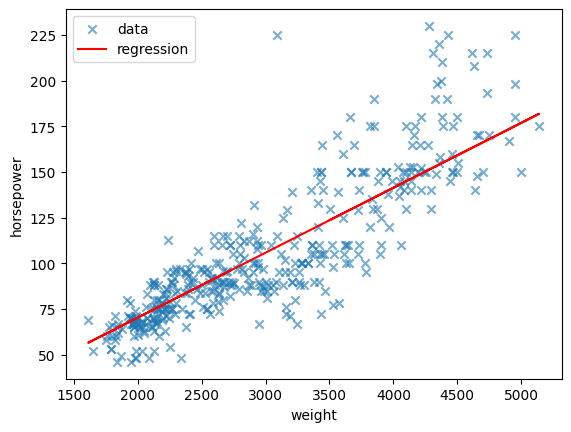

In [59]:
# Drop NaN values first (data.dropna() earlier didn't assign!)
clean_data = data.dropna()

x = clean_data["Weight"].values
t = clean_data["Horsepower"].values

# Normalize feature to [0, 1] range for stable gradient descent
x_max = np.max(x)
x_normalized = x / x_max

# Construct design matrix with normalized x for training
N = len(x)
X_norm = np.column_stack([np.ones(N), x_normalized])

w = np.zeros(2)

# Gradient descent iterations
learning_rate = 0.01
for i in range(10000):
    error = X_norm @ w - t
    gradient = X_norm.T @ error / N
    w = w - learning_rate * gradient

# Transform weights back to original scale for plotting
# w[1] was learned on x/x_max, so divide by x_max to get slope for original x
w_original = np.array([w[0], w[1] / x_max])

# Build X with original x values for plotting
X = np.column_stack([np.ones(N), x])

plot((w_original, X, t))